# Evaluating Forecasts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

plt.rcParams['figure.figsize'] = (14,6)

### Overview: 
Step 1 - 5: See encounter "Analyzing time series"  
Step 6 - 9: See encounter "Linear Autoregression"  
Step 10: Evaluating the model  
Step 11: Testing  
Step 12: Predicting into the future -> Exercise

# Step 1 - Load the Data

In [2]:
flights = pd.read_csv('flights.csv', index_col=0, parse_dates=True)
flights.head()

,passengers
date,
1949-01-01,64
1949-02-01,75
1949-03-01,98
1949-04-01,93
1949-05-01,80


In [3]:
flights.shape   # 12 years of motnhly data

(144, 1)

### Plot the data

In [4]:
def plot_flights(df, title='Monthly Passenger Numbers in 1000 over Time', ylim=True):
    '''
    Custom plotting function for plotting the flights dataset.
    
    Parameters
    ----------
    df : pd.DataFrame, the data to plot.
    title : str, the title of the plot.
    ylim : bool, whether to fix the minimum value of y; defalut is True.
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('# of Passengers in 1000')
    if ylim:
        plt.ylim(ymin=0)
    plt.show()

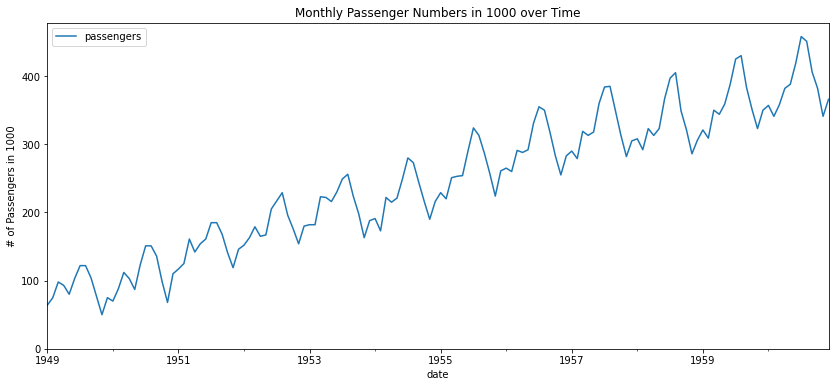

In [5]:
plot_flights(flights)

# Step 2 -  Train-Test-Split

In [6]:
# same as yesterday:
flights_train = flights[:'Dec 1959'].copy()
flights_test = flights['Jan 1960':].copy()

# Step 3 - Extract the Timestep and the Seasonal Dummies

In [7]:
# Create a timestep variable (trend)
flights_train['timestep'] = list(range(len(flights_train)))
flights_train.head()

,passengers,timestep
date,,
1949-01-01,64,0
1949-02-01,75,1
1949-03-01,98,2
1949-04-01,93,3
1949-05-01,80,4


In [8]:
# Create the seasonal dummies for seasonality
seasonal_dummies = pd.get_dummies(flights_train.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(flights_train.index)

flights_train = flights_train.join(seasonal_dummies)

In [9]:
flights_train.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
1949-01-01,64,0,0,0,0,0,0,0,0,0,0,0,0
1949-02-01,75,1,1,0,0,0,0,0,0,0,0,0,0
1949-03-01,98,2,0,1,0,0,0,0,0,0,0,0,0
1949-04-01,93,3,0,0,1,0,0,0,0,0,0,0,0
1949-05-01,80,4,0,0,0,1,0,0,0,0,0,0,0


# Step 4 Model the Trend_Seasonal model

In [10]:
# Define X and y
X = flights_train.drop(columns=['passengers'])
y = flights_train['passengers']

In [11]:
# Create and fit the model
m_ts = LinearRegression()
m_ts.fit(X, y)

LinearRegression()

In [12]:
# Create a new column with the predictions of the trend_seasonal model
flights_train['trend_seasonal'] = m_ts.predict(X)
flights_train.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
date,,,,,,,,,,,,,,
1949-01-01,64,0,0,0,0,0,0,0,0,0,0,0,0,59.594697
1949-02-01,75,1,1,0,0,0,0,0,0,0,0,0,0,57.503788
1949-03-01,98,2,0,1,0,0,0,0,0,0,0,0,0,90.503788
1949-04-01,93,3,0,0,1,0,0,0,0,0,0,0,0,83.412879
1949-05-01,80,4,0,0,0,1,0,0,0,0,0,0,0,85.231061


# Plot the original data and preliminary model

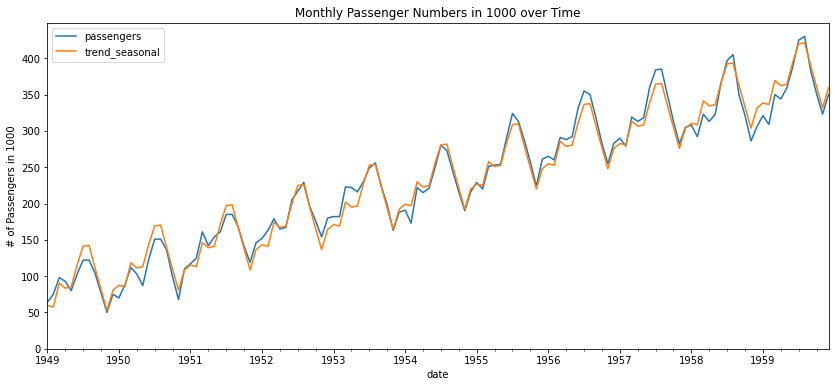

In [13]:
plot_flights(flights_train[['passengers', 'trend_seasonal']])

# Step 5 - Extract the remainder

In [14]:
# We want to extract the part of the model that the trend_seasonal is not able to explain
flights_train['remainder'] = flights_train['passengers'] - flights_train['trend_seasonal']

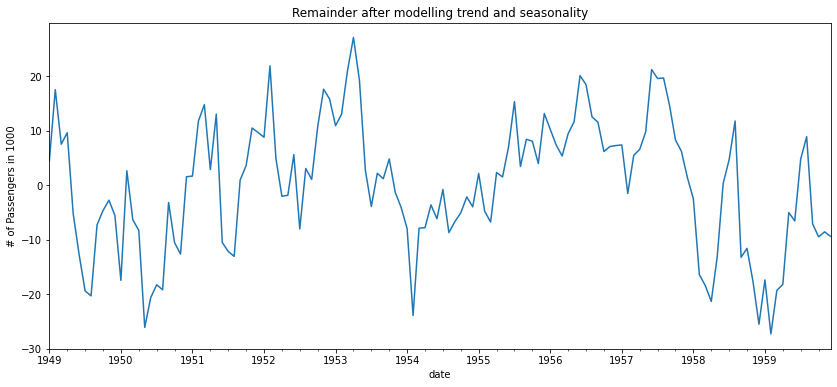

In [15]:
plot_flights(flights_train['remainder'], title='Remainder after modelling trend and seasonality', ylim=False)

# Step 6 - Inspect the remainder to decide how many lags to include


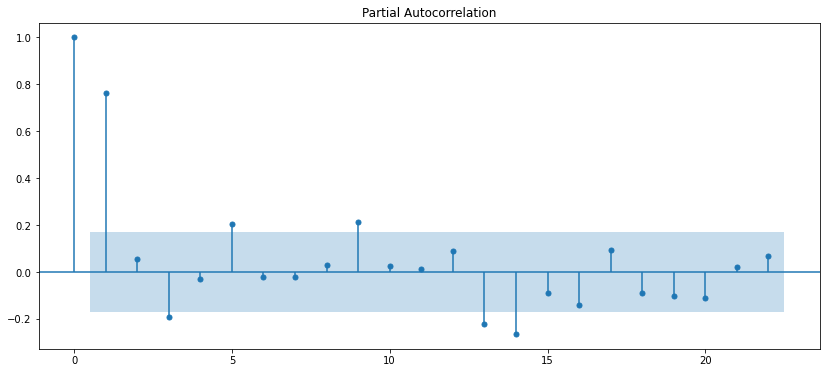

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(flights_train['remainder']);

# Step 7 - Add the lags of the remainder to the training data

In [17]:
flights_train['lag1'] = flights_train['remainder'].shift(1)
flights_train.dropna(inplace=True)
flights_train.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1
date,,,,,,,,,,,,,,,,
1949-02-01,75,1,1,0,0,0,0,0,0,0,0,0,0,57.503788,17.496212,4.405303
1949-03-01,98,2,0,1,0,0,0,0,0,0,0,0,0,90.503788,7.496212,17.496212
1949-04-01,93,3,0,0,1,0,0,0,0,0,0,0,0,83.412879,9.587121,7.496212
1949-05-01,80,4,0,0,0,1,0,0,0,0,0,0,0,85.231061,-5.231061,9.587121
1949-06-01,103,5,0,0,0,0,1,0,0,0,0,0,0,115.776515,-12.776515,-5.231061


# Step 8 - Run the full model

In [18]:
# Assign X
X_full = flights_train.drop(columns=['passengers', 'trend_seasonal', 'remainder'])
y_full = flights_train['passengers']

In [19]:
X_full.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
date,,,,,,,,,,,,,
1949-02-01,1,1,0,0,0,0,0,0,0,0,0,0,4.405303
1949-03-01,2,0,1,0,0,0,0,0,0,0,0,0,17.496212
1949-04-01,3,0,0,1,0,0,0,0,0,0,0,0,7.496212
1949-05-01,4,0,0,0,1,0,0,0,0,0,0,0,9.587121
1949-06-01,5,0,0,0,0,1,0,0,0,0,0,0,-5.231061


In [20]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)  #This is where the model learns

LinearRegression()

In [21]:
# Create a new predictions column
flights_train['predictions_full_model'] = m_full.predict(X_full)

In [22]:
flights_train

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
date,,,,,,,,,,,,,,,,,
1949-02-01,75,1,1,0,0,0,0,0,0,0,0,0,0,57.503788,17.496212,4.405303,60.911282
1949-03-01,98,2,0,1,0,0,0,0,0,0,0,0,0,90.503788,7.496212,17.496212,103.863524
1949-04-01,93,3,0,0,1,0,0,0,0,0,0,0,0,83.412879,9.587121,7.496212,89.170208
1949-05-01,80,4,0,0,0,1,0,0,0,0,0,0,0,85.231061,-5.231061,9.587121,92.577984
1949-06-01,103,5,0,0,0,0,1,0,0,0,0,0,0,115.776515,-12.776515,-5.231061,111.858054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959-08-01,430,127,0,0,0,0,0,0,1,0,0,0,0,421.132576,8.867424,4.776515,424.705473
1959-09-01,383,128,0,0,0,0,0,0,0,1,0,0,0,390.132576,-7.132576,8.867424,396.815548
1959-10-01,351,129,0,0,0,0,0,0,0,0,1,0,0,360.496212,-9.496212,-7.132576,355.015334


# Step 9 - Plot the prediction vs passengers for the training data

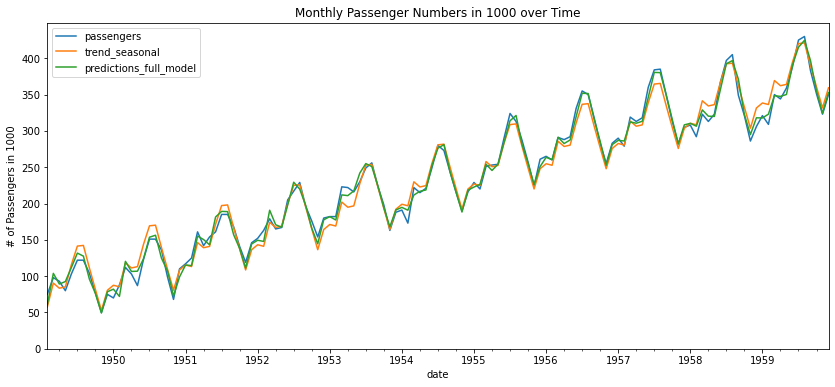

In [23]:
plot_flights(flights_train[['passengers', 'trend_seasonal', 'predictions_full_model']])

In [24]:
# Until here: nothing new. 

# Is this model good?

# Step 10 - Evaluate our model

We want to understand how good our model would work on data it has not been trained on. We can get an estimate of that by using cross-validation.

Cross-validation so far:

- Dividing training data into subsets (folds)
- in each iteration singled out one fold as validation set
- trained on the remaining training data and evaluated the fit on the validation set.

Cross-validation for time series:

- Dividing training data into subsets (folds)
- in the first iteration, use the first fold to evaluate the second fold
- in the second iteration, use the first and the second fold to evaluate the third fold
- ...

In [25]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [26]:
# See how the folds work: 
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f'The training data for the {i+1}th iteration are the observations {train_index[0]} to {train_index[-1]}')
    print(f'The validation data for the {i+1}th iteration are the observations {validation_index[0]} to {validation_index[-1]}')
    print()

The training data for the 1th iteration are the observations 0 to 25
The validation data for the 1th iteration are the observations 26 to 46

The training data for the 2th iteration are the observations 0 to 46
The validation data for the 2th iteration are the observations 47 to 67

The training data for the 3th iteration are the observations 0 to 67
The validation data for the 3th iteration are the observations 68 to 88

The training data for the 4th iteration are the observations 0 to 88
The validation data for the 4th iteration are the observations 89 to 109

The training data for the 5th iteration are the observations 0 to 109
The validation data for the 5th iteration are the observations 110 to 130



In [27]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full)

In [28]:
# Do the cross validation
result = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=time_series_split)
# scores are R-sqaured (default for LInear Regression in scikitlearn)

In [29]:
result.mean()

0.8957442586519804

# Evaluation Metrics Overview

### 1. Mean Absolute Error (MAE)

$\frac{1}{n} \sum |y_t - \hat{y}_t|$

#### Advantages:

- Error is in the unit of interest, interpretable
- Does not overly value outliers

#### Disadvantages:

- Not comparable across models with different units
- not the cheapest computationally

### 2. Mean-Squared-Error (MSE)

$\frac{1}{n} \sum (y_t - \hat{y_t}) ^2$

#### Advantages:
- Is widely implemented
- strong penalty on outliers

#### Disadvantages:
- Strong penalty on outliers
- Unit hardly interpretable
- Not comparable across models with different units

### 3. Root-Mean-Squared-Error (RMSE)

$\sqrt{\frac{1}{n} \sum (y_t - \hat{y_t}) ^2}$

#### Advantages:
- Errors in the unit of interest, but not as interpretable as MAE
- penalizes large errors

#### Disadvantages:
- Can only be compared between models whos errors are measured in the same unit

### 4. Root Mean Squared Log Error (RMSLE)

$\sqrt{\frac{1}{n} \sum (log(y_t + 1) - log(\hat{y_t} + 1) ^2}$

#### Advantages:
- Captures relative error
- Penalizes underestimation stronger than overestimation
- good when: target has exponential growth

### 5. Mean Absolute Percent Error (MAPE)

$\frac{1}{n} \sum |\frac{y_t - \hat{y}_t}{y_t}| * 100$

#### Advantages:
- Comparable over different models as it is scale independent
- intuitive interpretation

#### Disadvantages:
- Is not defined for 0 values
- unstable for very small values
- asymmetric: favours underestimations

### 6. $R^2$

$1 - \frac{\sum{(y_i - \hat{y_i})^2}}{\sum{(y_i - \bar{y})^2}}$

Goodness-of-Fit-Measure, proportion of variance explained by the model. 
Best possible score: 1. 

### 7. AIC (Akaike Information Criterion)
$2k − 2ln(\hat{L})$

Also Goodness-of-Fit-Measure. Relative information value, lower is better. Penalizes models with many parameters.  
Useful to compare models trained on the same dataset.

In [30]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

regr = OLS(y_full, add_constant(X_full)).fit()
regr.aic

935.541976707646

In [31]:
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             passengers   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1287.
Date:                Wed, 24 Feb 2021   Prob (F-statistic):          1.28e-119
Time:                        13:23:12   Log-Likelihood:                -453.77
No. Observations:                 131   AIC:                             935.5
Df Residuals:                     117   BIC:                             975.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.5034      2.873     20.361      0.000      52.813      64.194
timestep       2.3224      0.019    122.507      0.000       2.285       2.360
month_2       -3.2636      3.575     -0.913      0.363     -10.344       3.816
month_3       27.4139      3.575      7.669      0.000      20.335      34.493
month_4       18.0006      3.574      5.036      0.000      10.922      25.079
month_5       17.4963      3.574      4.895      0.000      10.418      24.574
month_6       45.7193      3.574     12.793      0.000      38.642      52.797
month_7       69.0332      3.574     19.317      0.000      61.956      76.111
month_8       67.6199      3.574     18.921      0.000      60.542      74.698
month_9       34.2974      3.574      9.596      0.000      27.219      41.375
month_10       2.3386      3.574      0.654      0.514      -4.740       9.417
month_11     -28.8929      3.575     -8.083      0.000     -35.972     -21.814
month_12      -3.3972      3.575     -0.950      0.344     -10.477       3.683
lag1           0.7602      0.060     12.595      0.000       0.641       0.880
==============================================================================
Omnibus:                        3.476   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.176   Jarque-Bera (JB):                3.249
Skew:                          -0.386   Prob(JB):                        0.197
Kurtosis:                       3.009   Cond. No.                         987.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 11) - Test your model

In [32]:
flights_train.tail(2)

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
date,,,,,,,,,,,,,,,,,
1959-11-01,323,130,0,0,0,0,0,0,0,0,0,1,0,331.587121,-8.587121,-9.496212,324.309311
1959-12-01,350,131,0,0,0,0,0,0,0,0,0,0,1,359.405303,-9.405303,-8.587121,352.818620


In [33]:
# Last timestep of the training data
last_train_timestep = flights_train['timestep'][-1]

In [34]:
last_train_timestep

131

In [35]:
# Create a timestep for the model
flights_test['timestep'] = list(range(last_train_timestep +1, last_train_timestep + 1 + len(flights_test)))

In [36]:
flights_test

,passengers,timestep
date,,
1960-01-01,357,132
1960-02-01,341,133
1960-03-01,358,134
1960-04-01,382,135
1960-05-01,388,136
1960-06-01,419,137
1960-07-01,458,138
1960-08-01,451,139
1960-09-01,406,140


In [37]:
# Create seasonal dummies
seasonal_dummies = pd.get_dummies(flights_test.index.month, 
                                  prefix='month', 
                                 drop_first=True).set_index(flights_test.index)

flights_test = flights_test.join(seasonal_dummies)
flights_test.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
1960-01-01,357,132,0,0,0,0,0,0,0,0,0,0,0
1960-02-01,341,133,1,0,0,0,0,0,0,0,0,0,0
1960-03-01,358,134,0,1,0,0,0,0,0,0,0,0,0
1960-04-01,382,135,0,0,1,0,0,0,0,0,0,0,0
1960-05-01,388,136,0,0,0,1,0,0,0,0,0,0,0


In [38]:
# Assign X_test
X_test = flights_test.drop(columns=['passengers'])

In [39]:
# Predict trend and seasonality
flights_test['trend_seasonal'] = m_ts.predict(X_test)

In [40]:
flights_test

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
date,,,,,,,,,,,,,,
1960-01-01,357,132,0,0,0,0,0,0,0,0,0,0,0,366.286364
1960-02-01,341,133,1,0,0,0,0,0,0,0,0,0,0,364.195455
1960-03-01,358,134,0,1,0,0,0,0,0,0,0,0,0,397.195455
1960-04-01,382,135,0,0,1,0,0,0,0,0,0,0,0,390.104545
1960-05-01,388,136,0,0,0,1,0,0,0,0,0,0,0,391.922727
1960-06-01,419,137,0,0,0,0,1,0,0,0,0,0,0,422.468182
1960-07-01,458,138,0,0,0,0,0,1,0,0,0,0,0,448.104545
1960-08-01,451,139,0,0,0,0,0,0,1,0,0,0,0,449.013636
1960-09-01,406,140,0,0,0,0,0,0,0,1,0,0,0,418.013636


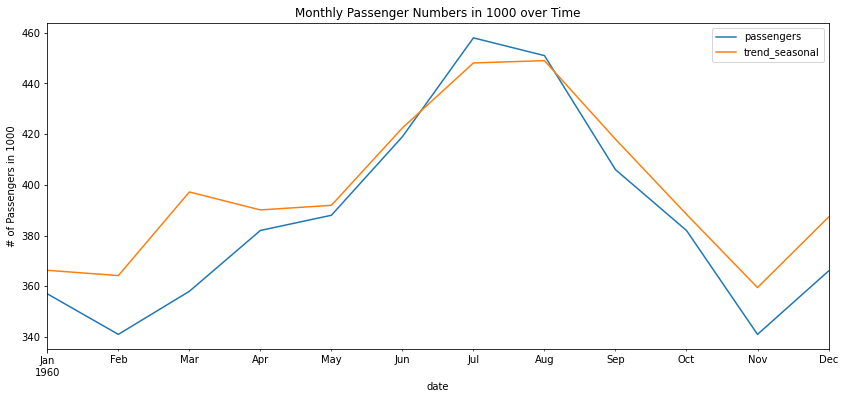

In [41]:
plot_flights(flights_test[['passengers', 'trend_seasonal']], ylim=False)

In [42]:
# Calculate the remainder for the test set
flights_test['remainder'] = flights_test['passengers'] - flights_test['trend_seasonal']

In [43]:
# Create the lagged variable
flights_test['lag1'] = flights_test['remainder'].shift(1)

In [44]:
# Assign X_full
X_full_t = flights_test.drop(columns=['passengers', 'trend_seasonal', 'remainder'])

In [45]:
X_full_t

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
date,,,,,,,,,,,,,
1960-01-01,132,0,0,0,0,0,0,0,0,0,0,0,NaN
1960-02-01,133,1,0,0,0,0,0,0,0,0,0,0,-9.286364
1960-03-01,134,0,1,0,0,0,0,0,0,0,0,0,-23.195455
1960-04-01,135,0,0,1,0,0,0,0,0,0,0,0,-39.195455
1960-05-01,136,0,0,0,1,0,0,0,0,0,0,0,-8.104545
1960-06-01,137,0,0,0,0,1,0,0,0,0,0,0,-3.922727
1960-07-01,138,0,0,0,0,0,1,0,0,0,0,0,-3.468182
1960-08-01,139,0,0,0,0,0,0,1,0,0,0,0,9.895455
1960-09-01,140,0,0,0,0,0,0,0,1,0,0,0,1.986364


In [46]:
X_full_t.loc['1960-01-01', 'lag1'] = flights_train.loc['1959-12-01', 'remainder']

In [47]:
# Create the predictions
flights_test['predictions_full_model'] = m_full.predict(X_full_t)

In [48]:
flights_test

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
date,,,,,,,,,,,,,,,,,
1960-01-01,357,132,0,0,0,0,0,0,0,0,0,0,0,366.286364,-9.286364,NaN,357.916266
1960-02-01,341,133,1,0,0,0,0,0,0,0,0,0,0,364.195455,-23.195455,-9.286364,357.065499
1960-03-01,358,134,0,1,0,0,0,0,0,0,0,0,0,397.195455,-39.195455,-23.195455,379.491242
1960-04-01,382,135,0,0,1,0,0,0,0,0,0,0,0,390.104545,-8.104545,-39.195455,360.236483
1960-05-01,388,136,0,0,0,1,0,0,0,0,0,0,0,391.922727,-3.922727,-8.104545,385.691237
1960-06-01,419,137,0,0,0,0,1,0,0,0,0,0,0,422.468182,-3.468182,-3.922727,419.415880
1960-07-01,458,138,0,0,0,0,0,1,0,0,0,0,0,448.104545,9.895455,-3.468182,445.397808
1960-08-01,451,139,0,0,0,0,0,0,1,0,0,0,0,449.013636,1.986364,9.895455,456.466478
1960-09-01,406,140,0,0,0,0,0,0,0,1,0,0,0,418.013636,-12.013636,1.986364,419.453666


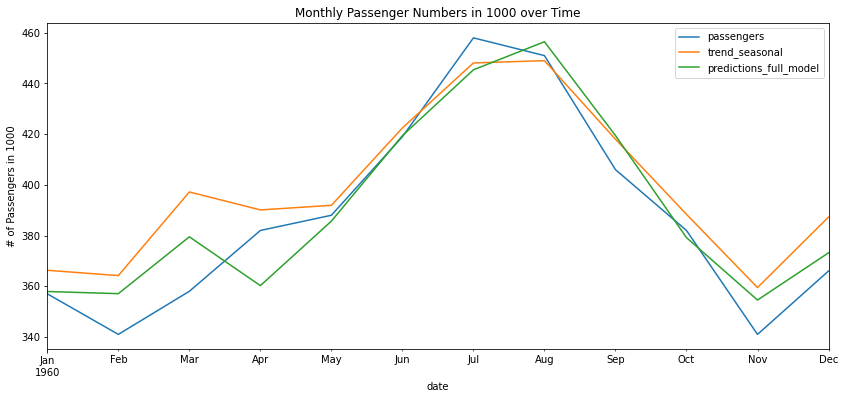

In [49]:
plot_flights(flights_test[['passengers', 'trend_seasonal', 'predictions_full_model']], ylim=False)

In [50]:
# Create the complete dataset and plot it
flights_full = flights_train[['passengers', 'trend_seasonal', 'predictions_full_model']].append(flights_test[['passengers', 'trend_seasonal', 'predictions_full_model']])

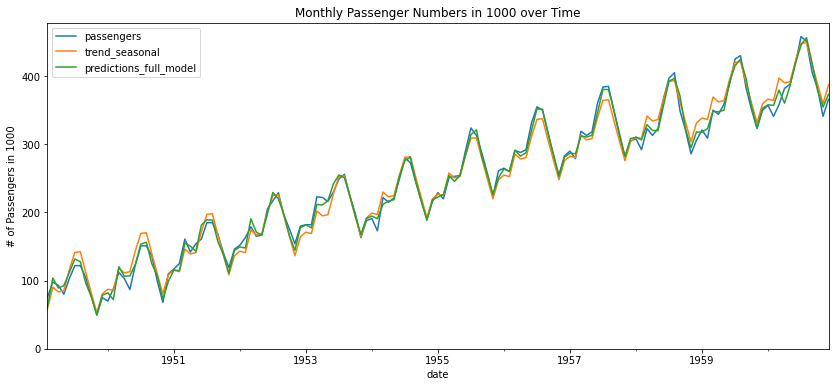

In [51]:
plot_flights(flights_full)

In [52]:
m_full.score(X_full_t, flights_test['passengers'])  

0.8932731911942137

# Exercise
1. Go trough Step 12, run and explore the code and try to see what is going on.   
Most of this is very similar to step 11, but you will be able to predict further into the future than your test-dataset! 

2. Then, apply cross-validation to the project-data. 

# Step 12 - Predict the future

So far we have just predicted data that we already had (train and test). We have not actually made any predictions for the future.

In [53]:
# Combine train and test data -> whole dataset with all features we created. 
flights_combined = flights_train.append(flights_test)
flights_combined.tail()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
date,,,,,,,,,,,,,,,,,
1960-08-01,451,139,0,0,0,0,0,0,1,0,0,0,0,449.013636,1.986364,9.895455,456.466478
1960-09-01,406,140,0,0,0,0,0,0,0,1,0,0,0,418.013636,-12.013636,1.986364,419.453666
1960-10-01,382,141,0,0,0,0,0,0,0,0,1,0,0,388.377273,-6.377273,-12.013636,379.173933
1960-11-01,341,142,0,0,0,0,0,0,0,0,0,1,0,359.468182,-18.468182,-6.377273,354.549835
1960-12-01,366,143,0,0,0,0,0,0,0,0,0,0,1,387.286364,-21.286364,-18.468182,373.176016


In [54]:
# Assign X and y 
X_combined = flights_combined.drop(columns=['passengers', 'trend_seasonal', 'remainder', 'predictions_full_model'])
y_combined = flights_combined['passengers']

In [55]:
X_combined.tail(12) # NaN for 1960-01-01

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
date,,,,,,,,,,,,,
1960-01-01,132,0,0,0,0,0,0,0,0,0,0,0,NaN
1960-02-01,133,1,0,0,0,0,0,0,0,0,0,0,-9.286364
1960-03-01,134,0,1,0,0,0,0,0,0,0,0,0,-23.195455
1960-04-01,135,0,0,1,0,0,0,0,0,0,0,0,-39.195455
1960-05-01,136,0,0,0,1,0,0,0,0,0,0,0,-8.104545
1960-06-01,137,0,0,0,0,1,0,0,0,0,0,0,-3.922727
1960-07-01,138,0,0,0,0,0,1,0,0,0,0,0,-3.468182
1960-08-01,139,0,0,0,0,0,0,1,0,0,0,0,9.895455
1960-09-01,140,0,0,0,0,0,0,0,1,0,0,0,1.986364


In [56]:
X_combined.loc['1960-01-01', 'lag1'] = flights_train.loc['1959-12-01', 'remainder']

In [57]:
# Re-train the model on the whole dataset
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

LinearRegression()

In [58]:
# What is the first date in the future? --> 1961-01-01
timestep = flights_combined['timestep'].max() + 1
months = [0] * 11  # because it is January, which is the first dummy-feature (which we dropped)
lag = flights_combined.loc['1960-12-01', 'remainder']

In [59]:
# create a new sample
X_future = []

In [60]:
X_future.append(timestep)
X_future

[144]

In [61]:
X_future.extend(months)
X_future

[144, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [62]:
X_future.append(lag)
X_future

[144, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -21.28636363636383]

In [63]:
X_future = pd.DataFrame([X_future], columns = ['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12','lag1'])
X_future.rename(index={0:pd.to_datetime("1961-01-01 00:00:00")},inplace=True)
X_future

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
1961-01-01,144,0,0,0,0,0,0,0,0,0,0,0,-21.286364


In [64]:
# Prediction for 1961-01-01
m_combined.predict(X_future)

array([376.10581815])

In [65]:
X_future['predictions_full_model'] = m_combined.predict(X_future)

In [66]:
# How does this look like for 1961-02-01?
timestep = flights_combined['timestep'].max() + 2
months = [1] + [0]*10
lag = 0 
# This is too far in the future to calculate the lag; our best guess will be a lag of 0. 
# So we are predicting only trend and seasonality here. 

In [67]:
X_future_2 = pd.DataFrame([[timestep] + months + [lag]], columns = ['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12','lag1'])
X_future_2.rename(index={0:pd.to_datetime("1961-02-01 00:00:00")},inplace=True)
X_future_2

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
1961-02-01,145,1,0,0,0,0,0,0,0,0,0,0,0


In [68]:
# Prediction for 1961-02-01
m_combined.predict(X_future_2)

array([389.79554877])

In [69]:
X_future_2['predictions_full_model'] = m_combined.predict(X_future_2)

In [70]:
# create one df for plotting
cols = ['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'lag1', 'passengers', 'trend_seasonal', 'predictions_full_model']
flights_f = flights_test[cols].append(X_future)
flights_future = flights_f.append(X_future_2)

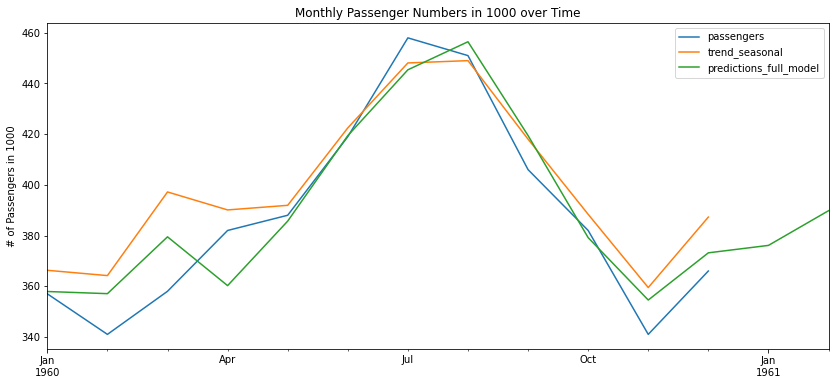

In [71]:
plot_flights(flights_future[['passengers', 'trend_seasonal', 'predictions_full_model']], ylim=False)